In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [25]:
!pip install np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, LSTM, concatenate, AveragePooling2D
from tensorflow.keras.layers import Subtract, Conv2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D, Embedding
from tensorflow.keras import regularizers
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

#tf.enable_eager_execution()

from matplotlib import pyplot as plt

import numpy as np

In [0]:
#parameters
epsilon = 0.031  #the quantity of perturbation we add to the images
step_pgd = 20   #the number of steps taken during the PGD algo
eta = 0.005     #used in PGD algo

# Data

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Network

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial = keras.models.Model(inputs=input, outputs=x)
adversarial.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history = adversarial.fit(x_train[:13000, :, :, :], y_train[:13000], batch_size=64, epochs=10, validation_split=0.2)

Train on 10400 samples, validate on 2600 samples
Epoch 1/10
10400/10400 [==============================] - 1s 119us/sample - loss: 1.9510 - accuracy: 0.2960 - val_loss: 1.7647 - val_accuracy: 0.3692
Epoch 2/10
10400/10400 [==============================] - 1s 76us/sample - loss: 1.6314 - accuracy: 0.4186 - val_loss: 1.5692 - val_accuracy: 0.4358
Epoch 3/10
10400/10400 [==============================] - 1s 77us/sample - loss: 1.4683 - accuracy: 0.4812 - val_loss: 1.4714 - val_accuracy: 0.4765
Epoch 4/10
10400/10400 [==============================] - 1s 75us/sample - loss: 1.3797 - accuracy: 0.5122 - val_loss: 1.4386 - val_accuracy: 0.4904
Epoch 5/10
10400/10400 [==============================] - 1s 77us/sample - loss: 1.3073 - accuracy: 0.5429 - val_loss: 1.4008 - val_accuracy: 0.5142
Epoch 6/10
10400/10400 [==============================] - 1s 77us/sample - loss: 1.2770 - accuracy: 0.5482 - val_loss: 1.3645 - val_accuracy: 0.5277
Epoch 7/10
10400/10400 [==============================] 

In [0]:
print(history.history)
print(type(history.history['acc']))

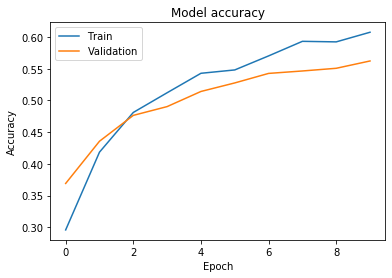

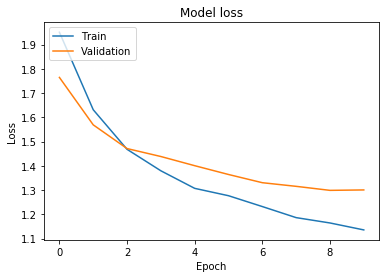

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Perturbations (FGSM, norme infinie)

In [38]:
#create the perturbations
#the perturbations are on the test set
image = tf.cast(x_test, tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_test, prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations = tf.sign(gradient).numpy()  #ne fonctionne pas sur jupyter notebook
#perturbations = np.asarray(tf.sign(gradient))
print(type(perturbations))
print(perturbations.shape)

x_test_fgsm = x_test + perturbations * epsilon

<class 'numpy.ndarray'>
(10000, 32, 32, 3)


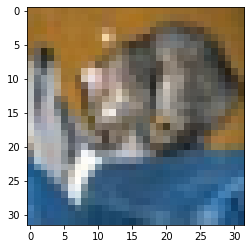

In [0]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


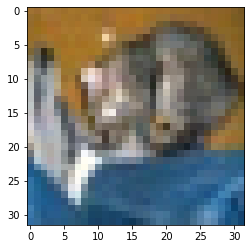

In [0]:
#the modified image (FGSM)
plt.imshow(x_test_fgsm[0].reshape((32, 32, 3)))
plt.show()

# Perturbations (PGD, norme infinie)

In [0]:
#create the perturbations
x_test_pgd = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)
    
for step in range(step_pgd):
  image = tf.cast(x_test_pgd, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
      
  perturbations = tf.sign(gradient).numpy()
  x_test_pgd = x_test_pgd + perturbations * eta
  x_test_pgd = np.maximum(np.minimum(x_test_pgd, x_test + epsilon), x_test - epsilon)

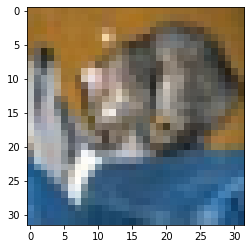

In [0]:
#the original image
plt.imshow(x_test[0].reshape((32, 32, 3)))
plt.show()

In [0]:
#the modified image (PGD)
plt.imshow(x_test_pgd[0].reshape((32, 32, 3)))
plt.show()

# Adversarial training FGSM

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial_trained = keras.models.Model(inputs=input, outputs=x)
adversarial_trained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
print(x_train.shape)

(50000, 32, 32, 3)


In [0]:
#boucle
nb_ex_modif = 14000
epochs = 10
x_train_adv = np.copy(x_train)
y_train_adv = np.copy(y_train)
histories = [0 for i in range(epochs)]
#training with the modified training set 
for i in range (epochs):
    histories[i] = adversarial_trained.fit(x_train_adv, y_train_adv, batch_size=64, epochs=1, validation_split=0.2)

    image = tf.cast(x_train_adv[:nb_ex_modif, :, :, :], tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = adversarial_trained(image)
      loss = tf.keras.losses.MSE(y_train_adv[:nb_ex_modif], prediction)

    gradient = tape.gradient(loss, image)
    print(tf.executing_eagerly())
    perturbations = tf.sign(gradient).numpy()
    x_train_adv[:nb_ex_modif, :, :, :] = x_train_adv[:nb_ex_modif, :, :, :] + perturbations * epsilon

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 5s 124us/sample - loss: 1.6633 - accuracy: 0.4084 - val_loss: 1.4328 - val_accuracy: 0.5029
True
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 67us/sample - loss: 1.6926 - accuracy: 0.3896 - val_loss: 1.4671 - val_accuracy: 0.4945
True
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 67us/sample - loss: 1.8088 - accuracy: 0.3539 - val_loss: 1.5694 - val_accuracy: 0.4504
True
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 67us/sample - loss: 1.8893 - accuracy: 0.3230 - val_loss: 1.6486 - val_accuracy: 0.4084
True
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 66us/sample - loss: 1.9313 - accuracy: 0.3056 - val_loss: 1.6632 - val_accuracy: 0.4095
True
Train on 40000 samples, validate o

In [0]:
tf.executing_eagerly()

In [0]:
#@title
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))


In [0]:
acc = [history.history['accuracy'][0] for history in histories]
val_acc = [history.history['val_accuracy'][0] for history in histories]
loss = [history.history['loss'][0] for history in histories]
val_loss = [history.history['val_loss'][0] for history in histories]

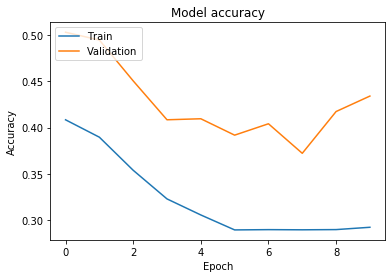

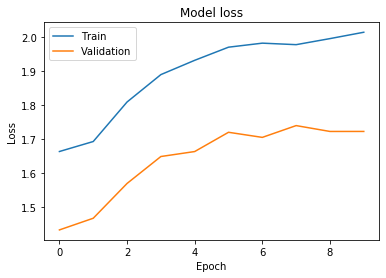

In [0]:
# Plot training & validation accuracy values
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Adversarial training PGD

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial_trained_PGD = keras.models.Model(inputs=input, outputs=x)
adversarial_trained_PGD.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
#boucle
nb_ex_modif = 14000
epochs = 10
x_train_adv_pgd = np.copy(x_train)
y_train_adv_pgd = np.copy(y_train)
histories = [0 for i in range(epochs)]
#training with the modified training set 
for i in range (epochs):
    histories[i] = adversarial_trained_PGD.fit(x_train_adv_pgd, y_train_adv_pgd, batch_size=64, epochs=1, validation_split=0.2)

    image = tf.cast(x_train_adv_pgd[:nb_ex_modif, :, :, :], tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = adversarial_trained_PGD(image)
      loss = tf.keras.losses.MSE(y_train_adv_pgd[:nb_ex_modif], prediction)

    gradient = tape.gradient(loss, image)
    perturbations = tf.sign(gradient).numpy()
    x_train_adv_pgd[:nb_ex_modif, :, :, :] = x_train_adv_pgd[:nb_ex_modif, :, :, :] + perturbations * eta
    x_train_adv_pgd[:nb_ex_modif, :, :, :] = np.maximum(np.minimum(x_train_adv_pgd[:nb_ex_modif, :, :, :], x_train[:nb_ex_modif, :, :, :] + epsilon), x_train[:nb_ex_modif, :, :, :] - epsilon)


Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 81us/sample - loss: 1.7340 - accuracy: 0.3747 - val_loss: 1.5248 - val_accuracy: 0.4628
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 68us/sample - loss: 1.4704 - accuracy: 0.4710 - val_loss: 1.4106 - val_accuracy: 0.5106
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 68us/sample - loss: 1.4443 - accuracy: 0.4819 - val_loss: 1.3287 - val_accuracy: 0.5443
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 69us/sample - loss: 1.4528 - accuracy: 0.4787 - val_loss: 1.2830 - val_accuracy: 0.5628
Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 3s 68us/sample - loss: 1.4582 - accuracy: 0.4751 - val_loss: 1.2579 - val_accuracy: 0.5741
Train on 40000 samples, validate on 10000 samples
40000/4000

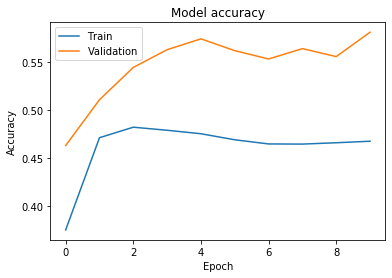

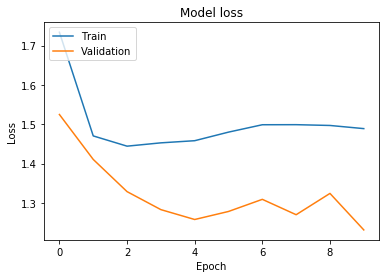

In [32]:
acc = [history.history['accuracy'][0] for history in histories]
val_acc = [history.history['val_accuracy'][0] for history in histories]
loss = [history.history['loss'][0] for history in histories]
val_loss = [history.history['val_loss'][0] for history in histories]

# Plot training & validation accuracy values
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Results

## Normal network

In [0]:
#results for the original image
print(adversarial.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#results for the FGSM-modified image
print(adversarial.evaluate(x_test_fgsm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#results for the PGD-modified image
print(adversarial.evaluate(x_test_pgd, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Trained network FGSM

In [0]:
#results for the modified image
print(adversarial_trained.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#results for the FGSM-modified image
print(adversarial_trained.evaluate(x_test_fgsm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#results for the PGD-modified image
print(adversarial_trained.evaluate(x_test_pgd, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Trained network PGD

In [34]:
print(adversarial_trained_PGD.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [40]:
#FGSM-modified images
print(adversarial_trained_PGD.evaluate(x_test_fgsm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [41]:
#PGD-modified images
print(adversarial_trained_PGD.evaluate(x_test_pgd, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Analyse des résultats

Nous pouvons observer qu'un réseau non entraîné contre les perturbations a pas mal d'accuracy sur des exemples normaux (55% ici) ; néanmoins, il tombe à 4% contre FGSM et à 2% contre PGD. 

Concernant les réseaux entraînés contre les perturbations, l'accuracy contre un jeu non modifié tombe à 17% (ce qui est vraiment pourri) ; le point positif est que, contre des exemples modifiés, l'accuracy est également à 17%. C'est donc meilleur que le réseau non entraîné. 

Une hypothèse réalisée ici est donc qu'il faudrait entraîner le réseau aussi contre des exemples non modifiés pour qu'il reste capable de bien les classifier. (hypothèse différente de celle du prof). 

Après test de l'hypothèse : 

On utilise un réseau entraîné contre 13000 exemples qui sont modifiés peu à peu et contre 37000 autres exemples qui restent tels quels. L'accuracy du jeu de test normal est à 46% (augmentation d'environ 30 points) ; celle du jeu FGSM est à 35% (augmentation de 20 points) ; celle du jeu PGD est à 36% (augmentation de 20 points aussi). 

L'hypothèse est donc validée. 



On a vu que le PGD fonctionne mieux que FGSM. Hypothèse : est-ce qu'en entraînant le réseau avec du PGD les résultats peuvent être meilleurs ? 

Après le test de l'hypothèse:

La plus grosse amélioration est constatée sur l'accuracy du jeu de test, on passe de 43% à 58%. (à retester ?). L'accuracy des autres jeux de données a été augmentée de 2 à 4%. 

L'hypothèse est donc validée. 